In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_com-jobs__20190501_20190731__30k_data.ldjson /tmp/jobs2019.ldjson
!gsutil cp gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_usa-indeed_usa_job__20200701_20200930__30k_data.ldjson /tmp/jobs2020.ldjson
!gsutil cp gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_usa-indeed_usa_job_data__20210401_20210630__30k_data.ldjson /tmp/jobs2021.ldjson

jobs2019 = pd.read_json(open('/tmp/jobs2019.ldjson'), lines=True)
jobs2020 = pd.read_json(open('/tmp/jobs2020.ldjson'), lines=True)
jobs2021 = pd.read_json(open('/tmp/jobs2021.ldjson'), lines=True)

Copying gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_com-jobs__20190501_20190731__30k_data.ldjson...
/ [1 files][195.4 MiB/195.4 MiB]                                                
Operation completed over 1 objects/195.4 MiB.                                    
Copying gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_usa-indeed_usa_job__20200701_20200930__30k_data.ldjson...
/ [1 files][244.0 MiB/244.0 MiB]                                                
Operation completed over 1 objects/244.0 MiB.                                    
Copying gs://indeed-jobs-2022/indeed_jobs/marketing_sample_for_indeed_usa-indeed_usa_job_data__20210401_20210630__30k_data.ldjson...
\ [1 files][246.9 MiB/246.9 MiB]                                                
Operation completed over 1 objects/246.9 MiB.                                    


# Data validation
- unfortunately, there were many exceptions to the included jobs; they were excluded if there were more than 2 entries with excepted keywords

In [16]:
# useable columns after inspection of data
columns = ['job_title', 'category', 'company_name', 'city', 'state', 'country', 'job_description']

# re-order and keep useable columns
jobs2019 = jobs2019[columns]
jobs2020 = jobs2020[columns]
jobs2021 = jobs2021[columns]

# add indicator var for years
jobs2019.loc[:, ['y20', 'y21']] = 0 
jobs2020.loc[:, 'y20'] = 1
jobs2020.loc[:, 'y21'] = 0
jobs2021.loc[:, 'y20'] = 0
jobs2021.loc[:, 'y21'] = 1

# combine datasets
df = pd.concat([jobs2019, jobs2020, jobs2021])

# filter country
df.loc[df['country'] == 'Usa', 'country'] = 'US'
df = df[df['country'] == 'US']

# format all strings to lowercase
for col in columns:
  df[col] = df[col].str.lower()

# filter job_titles
datajobs = ['data', 'analy', 'machine learning', 'business intelligence', 
            ' bi ', 'statistic', 'marketing scientist' ]
df = df[df['job_title'].str.contains('|'.join(datajobs))]

exceptionjobs = ['data entry', 'business', 'cultural', ' qa ', 'quality', 'lab', 'exploitation', 'clerk', ' qc ' , 'security', 'invest', 'bio', 'vulnerab', 'account', 
                 'portfolio', 'program', 'credit', 'treasury', 'imagery', 'intelligence', 'help desk', 'management analy', 'technical support', 'criminal', 'behavio', 
                 'field', 'policy', 'threat', 'pc', 'compliance']
df = df[~df['job_title'].str.contains('|'.join(exceptionjobs))]

# format state
df.loc[:, 'state'] = df['state'].str[:2]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 5 to 29907
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        2514 non-null   object
 1   category         2514 non-null   object
 2   company_name     2514 non-null   object
 3   city             2470 non-null   object
 4   state            2337 non-null   object
 5   country          2514 non-null   object
 6   job_description  2514 non-null   object
 7   y20              2514 non-null   int64 
 8   y21              2514 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 196.4+ KB


# Data mining; seniority, skills, and tools data
- indicator variables created for skills and tools 
- only used job description for skills and tools 
- note special handling for R in tools 
- one exception (risk manager) for seniority classification

In [5]:
# create seniority indicator variable
senior = ['ii', 'senior', 'manager']

df['seniority'] = 0
df.loc[(df['job_title'].str.contains('|'.join(senior))) | (df['job_description'].str.contains('|'.join(senior))),'seniority'] = 1
df.loc[(df['job_title'].str.contains('risk manager')),'seniority'] = 0

# create skill indicator variables
skills = ['transformation', 'technical', 'analysis', 'visualization']
df[skills] = [0, 0, 0, 0]

transform = ['clean', 'data prepar', 'transform', 'wrangl', 'manipulat', 'validat']
advanced = ['machine learn', 'ML', 'big data', 'engineer']
analytical = ['analy', 'statistic']
visual = ['visual', 'dashboard']

df.loc[df['job_description'].str.contains('|'.join(transform)),'transformation'] = 1
df.loc[df['job_description'].str.contains('|'.join(advanced)),'technical'] = 1
df.loc[df['job_description'].str.contains('|'.join(analytical)),'analysis'] = 1
df.loc[df['job_description'].str.contains('|'.join(visual)),'visualization'] = 1

# create tool indicator variables
tools = ['python', 'r', 'sql', 'excel', 'tableau', 'power bi']
df[tools] = [0, 0, 0, 0, 0, 0]

df.loc[df['job_description'].str.contains('python'),'python'] = 1
df.loc[df['job_description'].str.contains(' r | r,|rstudio'),'r'] = 1
df.loc[df['job_description'].str.contains('sql'),'sql'] = 1
df.loc[df['job_description'].str.contains('excel'),'excel'] = 1
df.loc[df['job_description'].str.contains('tableau'),'tableau'] = 1
df.loc[df['job_description'].str.contains('power bi'),'power bi'] = 1

df[skills].apply(df.value_counts), df[tools].apply(df.value_counts)



(   transformation  technical  analysis  visualization
 0            1678       1674       186           1963
 1             836        840      2328            551,
    python     r   sql  excel  tableau  power bi
 0    2146  2348  1856    967     2275      2420
 1     368   166   658   1547      239        94)

# Univariate analysis
- descriptive statistics for frequency of jobs vs state/region and industry

In [6]:
# create frequency table
statetable = df['state'].value_counts().rename_axis('state').reset_index(name='frequency')

# collapse to first 15 states, add rest to other
other_count = statetable.iloc[15:, 1].sum()
statetable.loc[len(statetable['state']),:] = ['other', other_count]
statetable = statetable.drop(list(range(15, 60)))

# add proportion, percentage
statetable['proportion'] = statetable['frequency'] / (statetable['frequency'].sum())
statetable['percent'] = statetable['proportion'].mul(100).round(1).astype(str) + '%'

statetable

,state,frequency,proportion,percent
0,ca,321.0,0.137356,13.7%
1,tx,198.0,0.084724,8.5%
2,ny,160.0,0.068464,6.8%
3,va,155.0,0.066324,6.6%
4,il,110.0,0.047069,4.7%
5,fl,109.0,0.046641,4.7%
6,md,83.0,0.035516,3.6%
7,ma,79.0,0.033804,3.4%
8,nc,76.0,0.032520,3.3%
9,ga,73.0,0.031237,3.1%


In [7]:
# create frequency table
industrytable = df['category'].value_counts().rename_axis('industry').reset_index(name='frequency')

# collapse to first 10 categories, add rest to 'other
other_count = industrytable.iloc[10:, 1].sum()
industrytable.loc[len(industrytable['industry']),:] = ['other', other_count]
industrytable = industrytable.drop(list(range(10, 41)))

# add proportion, percentage
industrytable['proportion'] = industrytable['frequency'] / (industrytable['frequency'].sum())
industrytable['percent'] = industrytable['proportion'].mul(100).round(1).astype(str) + '%'

industrytable

,industry,frequency,proportion,percent
0,computer-or-internet,529.0,0.210422,21.0%
1,accounting-or-finance,376.0,0.149562,15.0%
2,administrative,245.0,0.097454,9.7%
3,manufacturing-or-mechanical,185.0,0.073588,7.4%
4,banking-or-loans,159.0,0.063246,6.3%
5,engineering-or-architecture,157.0,0.062450,6.2%
6,upper-management-or-consulting,109.0,0.043357,4.3%
7,marketing-or-advertising-or-pr,76.0,0.030231,3.0%
8,accounting/finance,71.0,0.028242,2.8%
9,government-or-military,70.0,0.027844,2.8%


## Bivariate analysis

Check for relationships between seniority and variables of interest:
- since all categorical data, most appropriate method would be using chi-square test
- considered logistic regression
- can safely omit discussion of assumptions for chi-square test as frequency of every cell is quite large

Results:
- unexpected finding; more senior level workers for both having and not having a particular skill/tool
  - potential factor; some skills are more universal, whereas some skills not required for management focused roles?
  - exception/opposite or null effect: analysis, python, r, excel

- significant (p-value<0.05): analysis, visualization, excel, also sql nearly significant 
  - not sure for what reason these skills/tools relation with seniority 
  - potential factors:
    - suggests that basics are important (analysis, excel, sql)
    - also some skills are specialized? (visualization)

seniority         0    1
transformation          
0               766  912
1               361  475
Chi-sq value= 1.2759826897053277, p-value= 0.25864732455600536, Degrees of freedom= 1
seniority    0    1
technical          
0          762  912
1          365  475
Chi-sq value= 0.884760709269525, p-value= 0.34690106644001095, Degrees of freedom= 1
seniority     0     1
analysis             
0           104    82
1          1023  1305
Chi-sq value= 9.501126639428461, p-value= 0.0020534577317980105, Degrees of freedom= 1
seniority        0     1
visualization           
0              915  1048
1              212   339
Chi-sq value= 11.190564366653609, p-value= 0.0008221433525602478, Degrees of freedom= 1
seniority    0     1
python              
0          956  1190
1          171   197
Chi-sq value= 0.393531450766397, p-value= 0.5304489379004338, Degrees of freedom= 1
seniority     0     1
r                    
0          1047  1301
1            80    86
Chi-sq value= 0.67404421438375

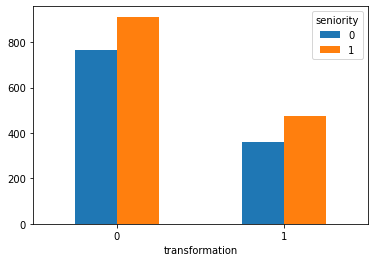

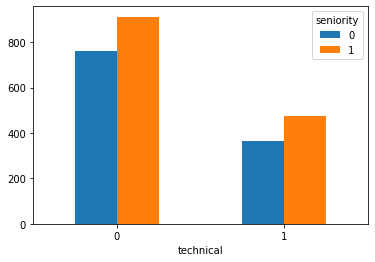

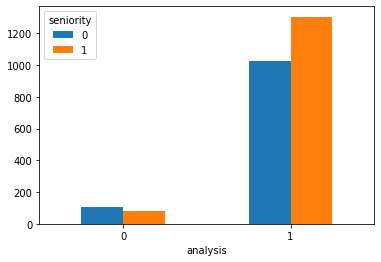

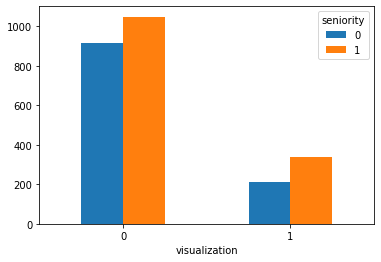

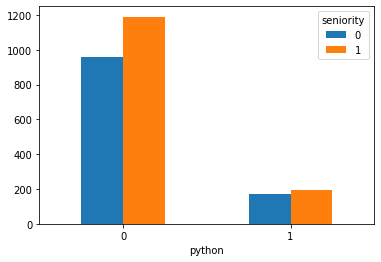

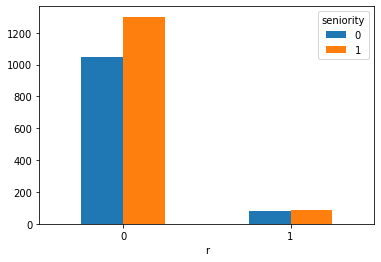

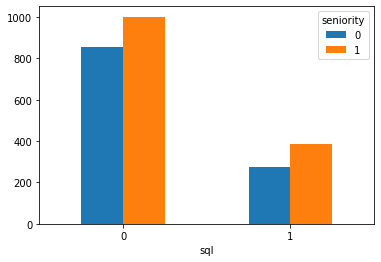

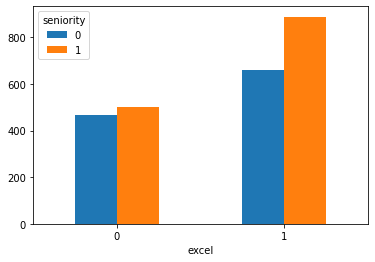

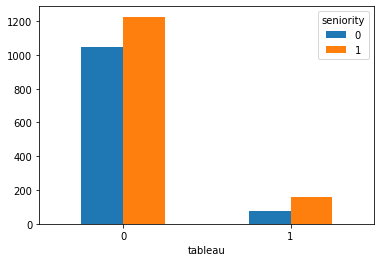

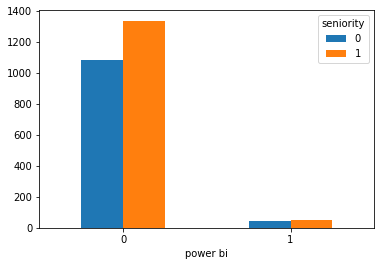

In [8]:
# contingency tables for skill vs seniority
for col in skills:
  crosstab = pd.crosstab(df[col], df['seniority'])
  print(crosstab)
  crosstab.plot.bar(rot=0)
  chi2, p, dof, expected = stats.chi2_contingency(crosstab)
  print(f"Chi-sq value= {chi2}, p-value= {p}, Degrees of freedom= {dof}")

# contingency tables for tools vs seniority
for col in tools:
  crosstab = pd.crosstab(df[col], df['seniority'])
  print(crosstab)
  crosstab.plot.bar(rot=0)
  chi2, p, dof, expected = stats.chi2_contingency(crosstab)
  print(f"Chi-sq value= {chi2}, p-value= {p}, Degrees of freedom= {dof}")


Check for balance of sample across years

In [9]:
print('2019 data:', len(df[(df['y20']==0) & (df['y21']==0)]), '\n2020 data:', df['y20'].sum(), '\n2021 data:', df['y21'].sum())

2019 data: 969 
2020 data: 772 
2021 data: 773


# Further analysis on skills vs seniority:
- considering the expected values and bar charts
  - analysis is associated with senior positions more than entry positions (more observed in senior positions and less observed in entry positions than expected)
  - visualization is associated with senior positions more than entry positions
  - excel is associated with senior positions more than entry positions
  - however, more seniors still did not have visualization skills compared to entry level (see charts), whereas the frequency is roughly equivalent for absence of analysis skills and excel; perhaps visualization is specialized skill which some senior positions requires, while if analysis and excel are required they remain important for senior positions  

seniority     0     1
analysis             
0           104    82
1          1023  1305
Chi-sq value= 9.501126639428461, p-value= 0.0020534577317980105, Degrees of freedom= 1, 
expected values: 
[[  83.38186158  102.61813842]
 [1043.61813842 1284.38186158]]
seniority        0     1
visualization           
0              915  1048
1              212   339
Chi-sq value= 11.190564366653609, p-value= 0.0008221433525602478, Degrees of freedom= 1, 
expected values: 
[[ 879.99244232 1083.00755768]
 [ 247.00755768  303.99244232]]
seniority    0    1
excel              
0          468  499
1          659  888
Chi-sq value= 7.856662566621351, p-value= 0.005063377006620638, Degrees of freedom= 1, 
expected values: 
[[433.49602228 533.50397772]
 [693.50397772 853.49602228]]


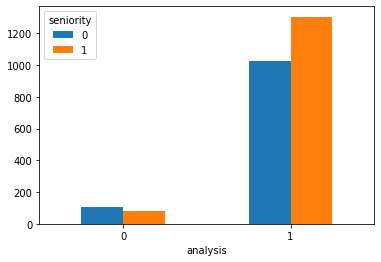

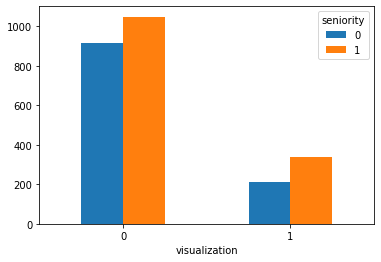

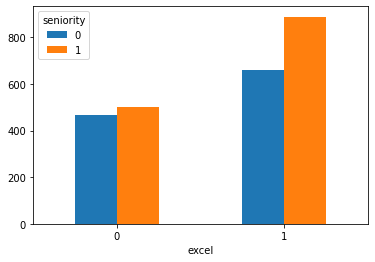

In [14]:
# consider significant variables
significant = ['analysis', 'visualization', 'excel']

# contingency tables with expected values
for col in significant:
  crosstab = pd.crosstab(df[col], df['seniority'])
  print(crosstab)
  crosstab.plot.bar(rot=0)
  chi2, p, dof, expected = stats.chi2_contingency(crosstab)
  print(f"Chi-sq value= {chi2}, p-value= {p}, Degrees of freedom= {dof}, \nexpected values: \n{expected}")